### Imports

In [1]:
import os
import gc
import glob
import json
from collections import defaultdict
import multiprocessing as mp
from pathlib import Path
from types import SimpleNamespace
from typing import Dict, List, Optional, Tuple
import warnings
from importlib import reload
import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas
import PIL.Image as Image
# disable PIL.DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = None

from sklearn.metrics import fbeta_score
from sklearn.exceptions import UndefinedMetricWarning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tqdm.auto import tqdm
warnings.simplefilter('ignore', UndefinedMetricWarning)

import utils

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

2023-06-03 17:13:11.625705: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-03 17:13:11.655081: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 17:13:12.094513: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


cuda


### Set up data

Today we'll work with a smaller dataset: a random selection of 4 rectangular pieces from each fragment.

Fragment 1 indices: 8,1, 11,1, 4,8, 7,2


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/32 [00:00<?, ?it/s]

Fragment 2 indices: 0,3, 5,3, 12,12, 7,4


Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/32 [00:00<?, ?it/s]

Fragment 3 indices: 2,2, 4,2, 3,8, 1,3


Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/32 [00:00<?, ?it/s]

14799 training items, 3700 validation items


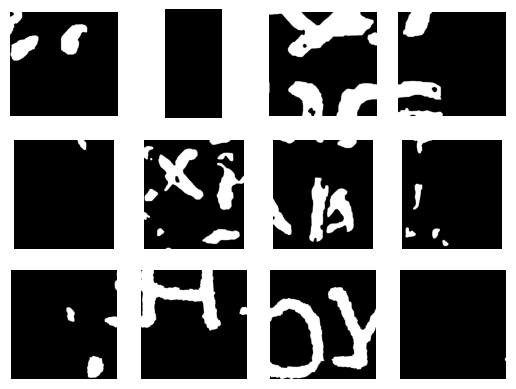

In [2]:
from sklearn.model_selection import train_test_split

BUFFER = 30  # Buffer size in x and y direction
Z_START = 16 # First slice in the z direction to use
Z_DIM = 32   # Number of slices in the z direction

# Define dataset
PREFIX = Path('data/pieces/train/')
dsets = []
for fragment in range(1, 4):
    # read the list of indices
    with open(PREFIX/str(fragment)/'pairs.txt', 'r') as f:
        indices = f.read().split("\n")
    random.seed(28)
    indices_to_use = random.choices(indices, k=4)
    print(f"Fragment {fragment} indices: {', '.join(indices_to_use)}")
    for i, index in enumerate(indices_to_use):
        dsets.append(utils.get_rect_dset(PREFIX/str(fragment)/index, Z_START, Z_DIM, BUFFER))
        # show fragments
        plt.subplot(3, 4, 4*(fragment-1)+i+1)
        plt.imshow(Image.open(PREFIX/str(fragment)/index/'inklabels.png'), cmap='gray')
        plt.axis('off')
full_dset = data.ConcatDataset(dsets)

# Split into training and validation
train_dset, val_dset = train_test_split(full_dset, test_size=0.2, random_state=4)
print(f"{len(train_dset)} training items, {len(val_dset)} validation items")

In [3]:
# define model
class InkDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()

        filters = [16, 32, 64]
        paddings = [1, 1, 1]
        kernel_sizes = [3, 3, 3]
        strides = [2, 2, 2]
        
        layers = []
        in_channels = 1
        for num_filters, padding, kernel_size, stride in zip(filters, paddings, kernel_sizes, strides):
            layers.extend([
                nn.Conv3d(
                    in_channels=in_channels,
                    out_channels=num_filters,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                ),
                nn.ReLU(inplace=True),
                torch.nn.BatchNorm3d(num_features=num_filters)
            ])
            in_channels = num_filters
        layers.append(nn.AdaptiveAvgPool3d(1))
        layers.append(nn.Flatten())

        self.encoder = nn.Sequential(*layers)
        self.decoder = nn.Sequential(
            nn.Linear(in_channels, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.decoder(features)

In [8]:
# define dataloaders
BATCH_SIZE = 32
torch.manual_seed(4)
train_loader = data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False)
print(f"{len(train_loader)} training batches, {len(val_loader)} validation batches")

463 training batches, 116 validation batches


### Learning rate range test
We now experiment with learning rates, using the learning rate range test described in [this paper](http://arxiv.org/abs/1506.01186). This test increases the learning rate linearly as training goes on, and plots learning rate vs. test loss. A good choice of learning rate is one where the test loss starts to level off.

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

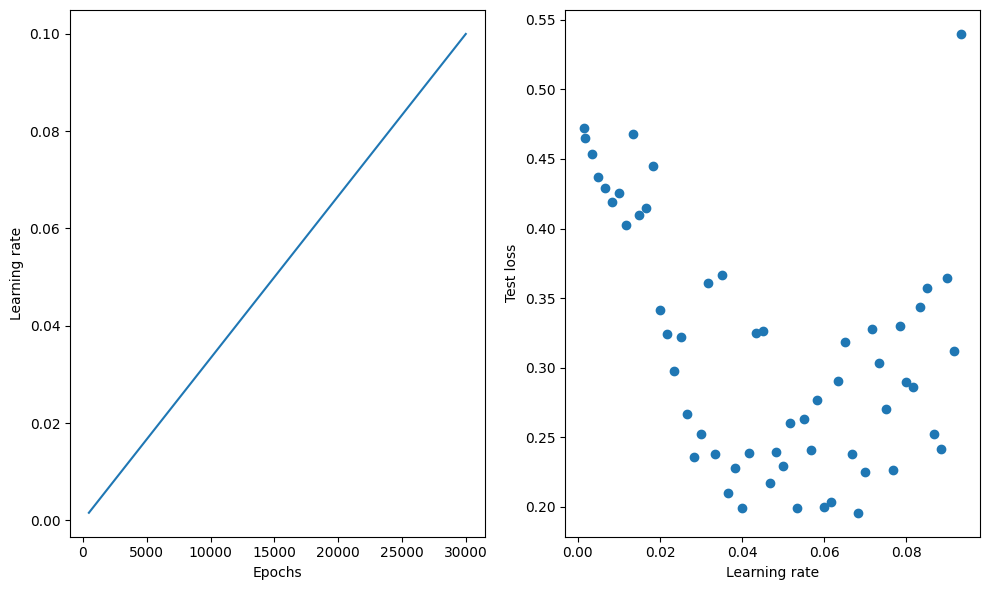

In [16]:
import utils.training
model = InkDetector().to(DEVICE)
TRAINING_EPOCHS = 30000 
VALIDATION_EPOCHS = 500
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD
scheduler = optim.lr_scheduler.CyclicLR
trainer = utils.Trainer(model, train_loader, val_loader,
                        optimizer=optimizer,
                        criterion=criterion,
                        lr=0.1,
                        scheduler=scheduler,
                        scheduler_base_lr=0.0,
                        scheduler_max_lr=0.1,
                        scheduler_step_size_up=TRAINING_EPOCHS, # only go up
                       )
trainer.train_eval_loop(TRAINING_EPOCHS, VALIDATION_EPOCHS)
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot(trainer.histories['epochs'], trainer.histories['lr'])
plt.gca().set(xlabel="Epochs", ylabel="Learning rate")
plt.subplot(122)
plt.scatter(trainer.histories['lr'], trainer.histories['val_loss'])
plt.gca().set(xlabel="Learning rate", ylabel="Test loss")
plt.tight_layout()

Great! It looks like the learning starts to level off around `lr=0.03` for this optimizer. Just for fun, let's also try out the Adam optimizer.

In [21]:
model = InkDetector().to(DEVICE)
TRAINING_EPOCHS = 30000 
VALIDATION_EPOCHS = 500
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam
scheduler = optim.lr_scheduler.CyclicLR
trainer = utils.Trainer(model, train_loader, val_loader,
                        optimizer=optimizer,
                        criterion=criterion,
                        lr=0.1,
                        scheduler=scheduler,
                        scheduler_base_lr=0.0,
                        scheduler_max_lr=0.1,
                        scheduler_step_size_up=TRAINING_EPOCHS, # only go up
                        scheduler_cycle_momentum=False,
                       )
trainer.train_eval_loop(TRAINING_EPOCHS, VALIDATION_EPOCHS)


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

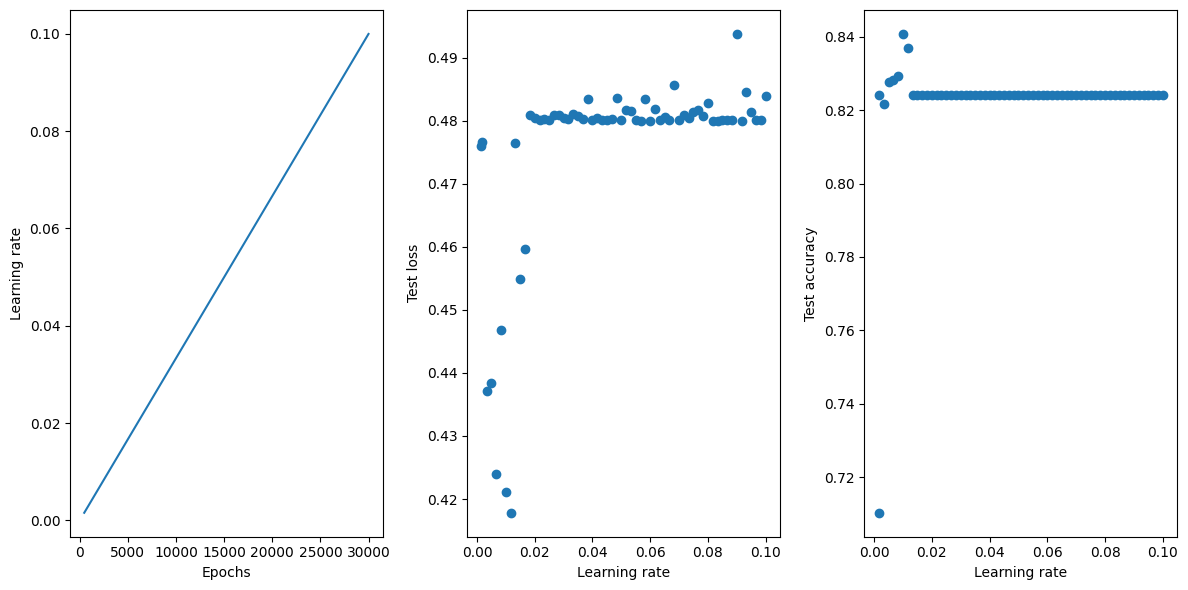

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.plot(trainer.histories['epochs'], trainer.histories['lr'])
plt.gca().set(xlabel="Epochs", ylabel="Learning rate")
plt.subplot(132)
plt.scatter(trainer.histories['lr'], trainer.histories['val_loss'])
plt.gca().set(xlabel="Learning rate", ylabel="Test loss")
plt.subplot(133)
plt.scatter(trainer.histories['lr'], trainer.histories['val_acc'])
plt.gca().set(xlabel="Learning rate", ylabel="Test accuracy")
plt.tight_layout()

Same thing with a smaller range of learning rates:

In [24]:
model = InkDetector().to(DEVICE)
TRAINING_EPOCHS = 30000 
VALIDATION_EPOCHS = 500
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam
scheduler = optim.lr_scheduler.CyclicLR
trainer = utils.Trainer(model, train_loader, val_loader,
                        optimizer=optimizer,
                        criterion=criterion,
                        lr=0.02,
                        scheduler=scheduler,
                        scheduler_base_lr=0.0,
                        scheduler_max_lr=0.02,
                        scheduler_step_size_up=TRAINING_EPOCHS, # only go up
                        scheduler_cycle_momentum=False,
                       )
trainer.train_eval_loop(TRAINING_EPOCHS, VALIDATION_EPOCHS)

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

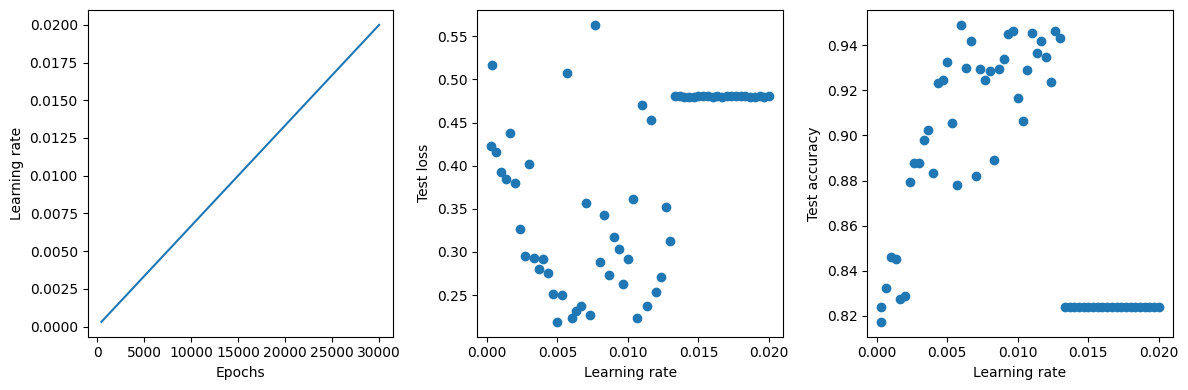

In [29]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(trainer.histories['epochs'], trainer.histories['lr'])
plt.gca().set(xlabel="Epochs", ylabel="Learning rate")
plt.subplot(132)
plt.scatter(trainer.histories['lr'], trainer.histories['val_loss'])
plt.gca().set(xlabel="Learning rate", ylabel="Test loss")
plt.subplot(133)
plt.scatter(trainer.histories['lr'], trainer.histories['val_acc'])
plt.gca().set(xlabel="Learning rate", ylabel="Test accuracy")
plt.tight_layout()

Test accuracy with Adam levels off around learning rate 0.005, and the model dies at learning rates above 0.013.

## Experiments with training hyperparameters
The following attributes of the training setup could be tweaked:
- **Optimizer-scheduler:** SGD with constant learning rate, SGD with CyclicLR policy, SGD with OneCycleLR policy, Adam with constant learning rate
    - Learning rate scheduling apparently doesn't work as well with Adam, which internally is doing something like dynamically adjusting the learning rate
- **Batch size:** I'll do 8, 16, 32, 64.
- **Learning rate:** For the constant learning rate policies, I'll try 3e-3, 1e-2, and 3e-2.
- **Layers to use:** `Z_DIM` in {8, 16, 32}, `Z_START` in {0, 8, 16, 24, 32, 40, 48, 56}.
- **Buffer size:** We currently have 30 (so a 61x61 square). I'll also try 15.

There are a few modifications which I will hold off on for now, but mention here anyway.
- **Optimizer parameters:** If one optimizer setup is clearly better, we can then think about tweaking optimizer parameter such as momentum. I'd prefer to wait on this until I've seen how the optimizers perform at base.
- **Data augmentation:** With or without random reflections in the cardinal directions. This is less pressing because it's a strategy for preventing overfitting, which we don't yet have a problem with.
- **Regularization:** The first things that come to mind are weight decay and early stopping. Again, these are strategies for preventing overfitting.
- **Denoising the data:** By using the updated masks provided by Brett Olsen. I am skipping this because it would affect the dataset in a positionally-dependent way, and I'm just working with a small piece of the full dataset. To experiment with this, we should focus on pieces of the dataset around the places that differ between the two masks.
- **Multi-fragment training strategies:** Some way to deal with the observation that fragment 2 is very different than fragments 1 and 3 -- do we train longer on fragment 2? Do we ignore fragment 2 at first and see if we can attain generalization from fragment 1 to 3? Do we do some kind of normalization? I'm skipping this because I don't yet know how to experiment with it rigorously.

Now, the appropriate way to deal with a bunch of hyperparameters is to do a randomized or grid search. At this exploratory stage, I'm going to modify them one at a time. I hope this will give us a sense for which ones are useless and which ones have a noticeable effect. To start, let me establish a baseline -- the training setup we've been using -- that's capable of learning our small dataset.


In [12]:
import time
from utils import Trainer, create_writer
BATCH_SIZE = 32
LEARNING_RATE = 0.03
tic = time.perf_counter()
train_loader = data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False)
model = InkDetector().to(DEVICE)
MODEL_NAME = "InkDetector_small_dataset_base"
MODEL_SAVE_PATH = "trained_models/" + MODEL_NAME + ".pt"
TRAINING_EPOCHS = 30000 
VALIDATION_EPOCHS = 500
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD
scheduler = optim.lr_scheduler.OneCycleLR
writer = create_writer(model_name=MODEL_NAME)
trainer = Trainer(model, train_loader, val_loader,
                  optimizer=optimizer,
                  criterion=criterion,
                  lr=LEARNING_RATE,
                  scheduler=scheduler,
                  scheduler_total_steps=TRAINING_EPOCHS,
                  scheduler_max_lr=LEARNING_RATE,
                  writer=writer)

trainer.train_eval_loop(TRAINING_EPOCHS, VALIDATION_EPOCHS)

torch.save(model.state_dict(), MODEL_SAVE_PATH)
toc = time.perf_counter()
runtime = toc - tic
print(f"Finished in {runtime/60:.0f}m{runtime - 60*int(runtime/60):.0f}s")

# clean up
del model, train_loader, val_loader
    
    

Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_base.


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 9m13s


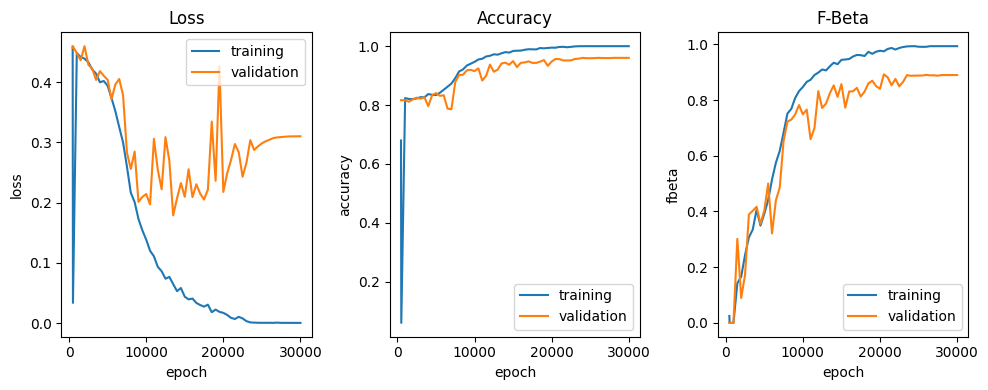

In [15]:
plt.figure(figsize=(10, 4))
trainer.plot_metrics()

This model reached accuracy = 1.0 on the training set. It begins to overfit aorund 9500 epoochs. It may be reasonable to try larger datasets and shorter training times.

### Optimizers and schedulers

In [55]:
import time
from utils import Trainer, create_writer
BATCH_SIZE = 32
trainers = dict()
for kwargs in [
    {'optimizer': torch.optim.SGD, 'lr': 0.03, 'scheduler': None,
     'model_name': 'InkDetector_small_dataset_SGD_constant_lr'},
    {'optimizer': torch.optim.SGD, 'lr': 0.03,
     'scheduler': torch.optim.lr_scheduler.CyclicLR,
     'scheduler_base_lr': 0.001,
     'scheduler_max_lr': 0.03,
     'model_name': 'InkDetector_small_dataset_SGD_cyclic_lr'},
    {'optimizer': torch.optim.Adam, 'lr': 0.005, 'scheduler': None,
     'model_name': 'InkDetector_small_dataset_Adam_constant_lr'}
]:
    MODEL_NAME = kwargs.pop('model_name')
    MODEL_SAVE_PATH = "trained_models/" + MODEL_NAME + ".pt"
    tic = time.perf_counter()
    train_loader = data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False)
    model = InkDetector().to(DEVICE)
    TRAINING_EPOCHS = 30000 
    VALIDATION_EPOCHS = 500
    criterion = nn.BCEWithLogitsLoss()
    writer = create_writer(model_name=MODEL_NAME)
    trainer = Trainer(model, train_loader, val_loader,
                      criterion=criterion,
                      writer=writer,
                      **kwargs)
    print(f"Training {MODEL_NAME}...")
    print("Parameters:", trainer.optimizer, trainer.optimizer_kwargs, trainer.scheduler_class, trainer.scheduler_kwargs)
    # save reference to trainer
    trainers[MODEL_NAME] = trainer

    trainer.train_eval_loop(TRAINING_EPOCHS, VALIDATION_EPOCHS)

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    toc = time.perf_counter()
    runtime = toc - tic
    print(f"Finished in {runtime/60:.0f}m{runtime - 60*int(runtime/60):.0f}s")

    # clean up
    del model, train_loader, val_loader



Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_SGD_constant_lr.
Training InkDetector_small_dataset_SGD_constant_lr...
Parameters: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.03
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
) {} None {'max_lr': 0.03}


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 5m31s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_SGD_cyclic_lr.
Training InkDetector_small_dataset_SGD_cyclic_lr...
Parameters: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.03
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
) {} <class 'torch.optim.lr_scheduler.CyclicLR'> {'max_lr': 0.03, 'base_lr': 0.001}


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 4m29s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_Adam_constant_lr.
Training InkDetector_small_dataset_Adam_constant_lr...
Parameters: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0
) {} None {'max_lr': 0.005}


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 5m33s


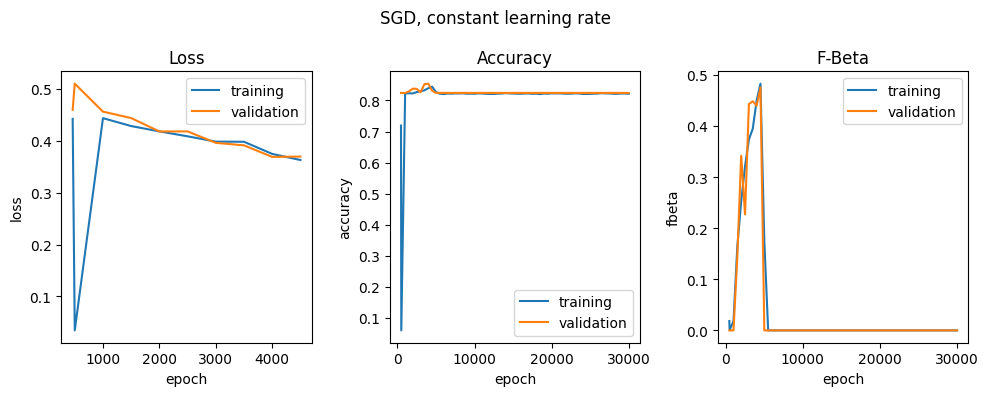

In [57]:
plt.figure(figsize=(10, 4))
plt.suptitle("SGD, constant learning rate")
trainers['InkDetector_small_dataset_SGD_constant_lr'].plot_metrics()

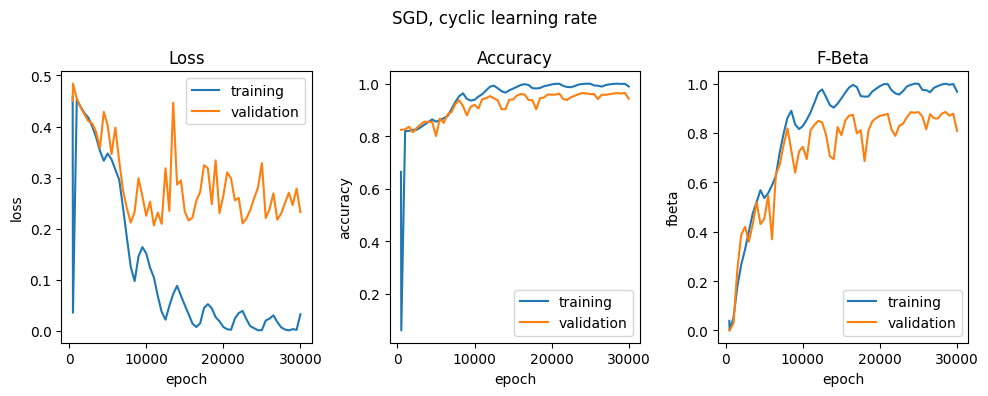

In [58]:
plt.figure(figsize=(10, 4))
plt.suptitle("SGD, cyclic learning rate")
trainers['InkDetector_small_dataset_SGD_cyclic_lr'].plot_metrics()

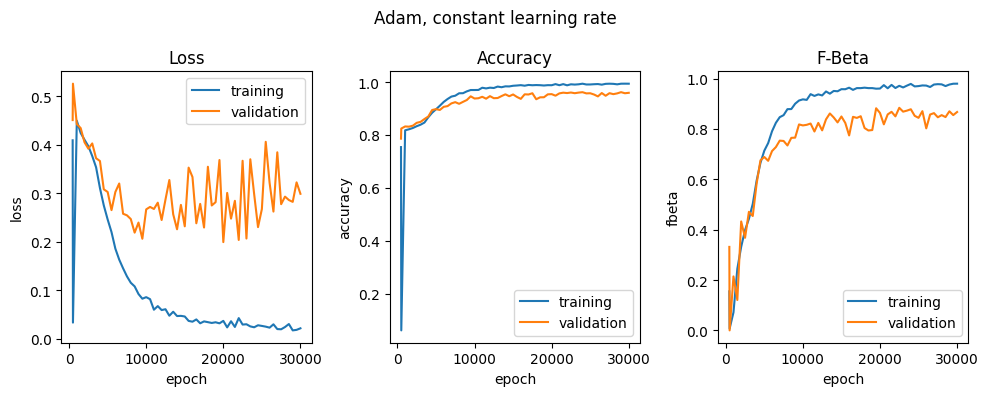

In [59]:
plt.figure(figsize=(10, 4))
plt.suptitle("Adam, constant learning rate")
trainers['InkDetector_small_dataset_Adam_constant_lr'].plot_metrics()

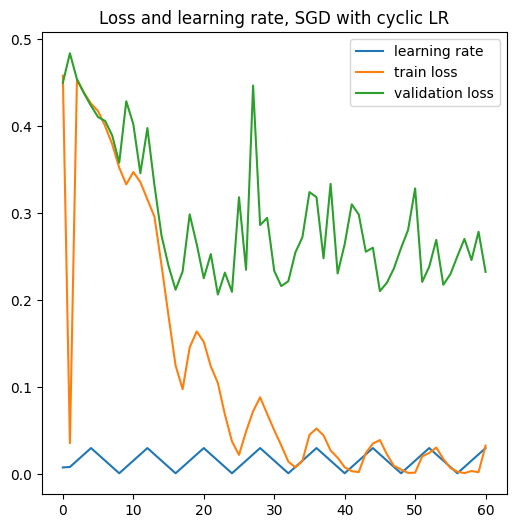

In [66]:
plt.figure(figsize=(6, 6))
plt.plot(trainers['InkDetector_small_dataset_SGD_cyclic_lr'].histories['lr'], label="learning rate")
plt.plot(trainers['InkDetector_small_dataset_SGD_cyclic_lr'].histories['train_loss'], label="train loss")
plt.plot(trainers['InkDetector_small_dataset_SGD_cyclic_lr'].histories['val_loss'], label="validation loss")
plt.legend()
plt.title("Loss and learning rate, SGD with cyclic LR");

#### Observations
- Adam with a constant learning rate is roughly comparable to SGD with the OneCycleLR policy. However, Adam topped out at training $F_{0.5}$ of $0.98$, while SGD with OneCycleLR essentially reached perfection on the training set. The test metrics seemed about the same.
- SGD with a constant learning rate died. 0.03 was near the top end of acceptable learning rates, so if we try this again, we should aim a bit lower.
- SGD with cyclic learning rate also performed comparably to SGD with OneCycleLR, though as with Adam, it was not able to memorize the training set. In this case, it's clear that the cycles to large learning rates pushed the algorithm away from the loss minimum it had discovered. We can see this if we plot the metrics against learning rate (see the last cell above). This is part of the justification for OneCycleLR, which involves a single ramp-up and ramp-down, and suggests that cyclic learning rate scheduling ought to be combined with learning rate decay, or only used initially.

All this suggests that there's no reason to change from the policy we've been using (SGD with OneCycleLR).

### Batch sizes

In [68]:
trainers_batches = dict()
for BATCH_SIZE in [8, 16, 32, 64]:
    MODEL_NAME = f'InkDetector_small_dataset_batch_size_{BATCH_SIZE}'
    MODEL_SAVE_PATH = "trained_models/" + MODEL_NAME + ".pt"
    # We adjust the training time so each model sees the same number of items.
    # This means that care has to be taken when comparing plots.
    TRAINING_EPOCHS = 30000 * 32 // BATCH_SIZE
    VALIDATION_EPOCHS = 500 * 32 // BATCH_SIZE
    model = InkDetector().to(DEVICE)
    kwargs = {'criterion': nn.BCEWithLogitsLoss(),
              'optimizer': torch.optim.SGD,
              'lr': 0.03,
              'scheduler': torch.optim.lr_scheduler.OneCycleLR,
              'scheduler_total_steps': TRAINING_EPOCHS,
              'scheduler_max_lr': 0.03}
    writer = create_writer(model_name=MODEL_NAME)
    
    train_loader = data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False)
    
    tic = time.perf_counter()
    trainer = Trainer(model, train_loader, val_loader,
                      **kwargs)
    print(f"Training {MODEL_NAME}...")
    # save reference to trainer
    trainers_batches[MODEL_NAME] = trainer

    trainer.train_eval_loop(TRAINING_EPOCHS, VALIDATION_EPOCHS)

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    toc = time.perf_counter()
    runtime = toc - tic
    print(f"Finished in {runtime/60:.0f}m{runtime - 60*int(runtime/60):.0f}s")

    # clean up
    del model, train_loader, val_loader


Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_batch_size_8.
Training InkDetector_small_dataset_batch_size_8...


Training:   0%|          | 0/600000 [00:00<?, ?it/s]

Finished in 10m27s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_batch_size_16.
Training InkDetector_small_dataset_batch_size_16...


Training:   0%|          | 0/180000 [00:00<?, ?it/s]

Finished in 6m18s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_batch_size_32.
Training InkDetector_small_dataset_batch_size_32...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 4m29s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_batch_size_64.
Training InkDetector_small_dataset_batch_size_64...


Training:   0%|          | 0/22500 [00:00<?, ?it/s]

Finished in 4m50s


Forgot to write to Tensorboard... Here are the graphs, though.

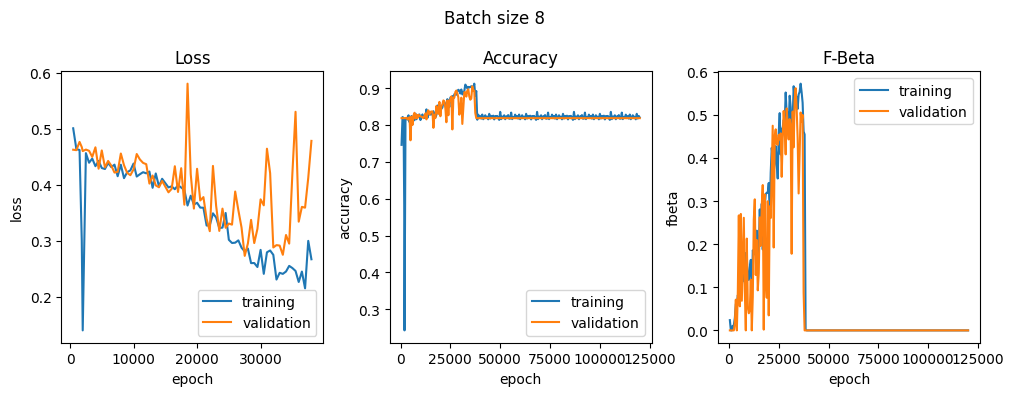

In [71]:
plt.figure(figsize=(10, 4))
plt.suptitle("Batch size 8")
trainers_batches['InkDetector_small_dataset_batch_size_8'].plot_metrics()
# I believe that the loss plot stops early because the loss is NaN after this point

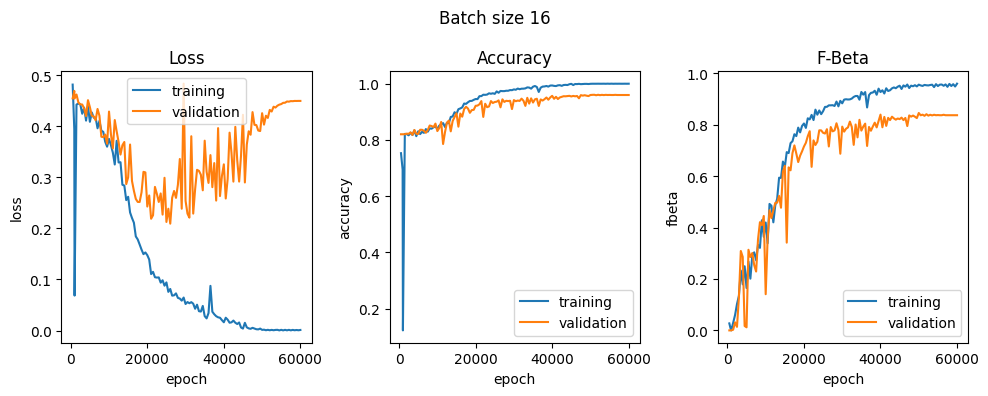

In [72]:
plt.figure(figsize=(10, 4))
plt.suptitle("Batch size 16")
trainers_batches['InkDetector_small_dataset_batch_size_16'].plot_metrics()

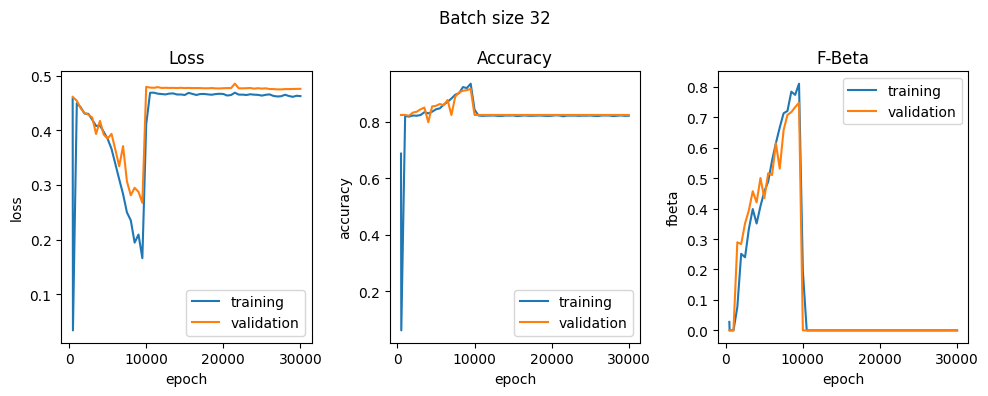

In [73]:
plt.figure(figsize=(10, 4))
plt.suptitle("Batch size 32")
trainers_batches['InkDetector_small_dataset_batch_size_32'].plot_metrics()

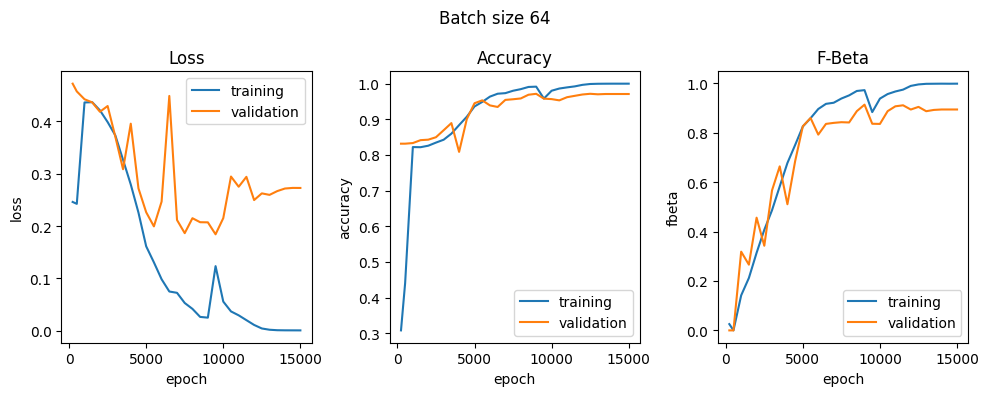

In [74]:
plt.figure(figsize=(10, 4))
plt.suptitle("Batch size 64")
trainers_batches['InkDetector_small_dataset_batch_size_64'].plot_metrics()

#### Observations
I'm not sure what to make of this. The fact that batch sizes 8 and 32 would die but that 16 wouldn't seems like an artifact of initialization. It should be noticed that the two models that died did so about 1/3 of the way through the training, which is when the learning rate scheduler is at its maximum.

In any case, since batch size 64 works and is fast on my machine, there seems no reason not to use it.

I'm going to rerun the experiment with a different initial state and a slightly lower maximum learning rate. I'm also going to log things to Tensorboard this time.

In [75]:
trainers_batches = dict()
for BATCH_SIZE in [8, 16, 32, 64]:
    MODEL_NAME = f'InkDetector_small_dataset_batch_size_{BATCH_SIZE}'
    MODEL_SAVE_PATH = "trained_models/" + MODEL_NAME + ".pt"
    # We adjust the training time so each model sees the same number of items.
    # This means that care has to be taken when comparing plots.
    TRAINING_EPOCHS = 30000 * 32 // BATCH_SIZE
    VALIDATION_EPOCHS = 500 * 32 // BATCH_SIZE
    model = InkDetector().to(DEVICE)
    kwargs = {'criterion': nn.BCEWithLogitsLoss(),
              'optimizer': torch.optim.SGD,
              'lr': 0.02,
              'scheduler': torch.optim.lr_scheduler.OneCycleLR,
              'scheduler_total_steps': TRAINING_EPOCHS,
              'scheduler_max_lr': 0.02}
    writer = create_writer(model_name=MODEL_NAME)
    
    train_loader = data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False)
    
    tic = time.perf_counter()
    trainer = Trainer(model, train_loader, val_loader, writer=writer, **kwargs)
    print(f"Training {MODEL_NAME}...")
    # save reference to trainer
    trainers_batches[MODEL_NAME] = trainer

    trainer.train_eval_loop(TRAINING_EPOCHS, VALIDATION_EPOCHS)

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    toc = time.perf_counter()
    runtime = toc - tic
    print(f"Finished in {runtime/60:.0f}m{runtime - 60*int(runtime/60):.0f}s")

    # clean up
    del model, train_loader, val_loader

Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_batch_size_8.
Training InkDetector_small_dataset_batch_size_8...


Training:   0%|          | 0/600000 [00:00<?, ?it/s]

Finished in 11m33s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_batch_size_16.
Training InkDetector_small_dataset_batch_size_16...


Training:   0%|          | 0/180000 [00:00<?, ?it/s]

Finished in 6m10s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_batch_size_32.
Training InkDetector_small_dataset_batch_size_32...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 4m27s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_batch_size_64.
Training InkDetector_small_dataset_batch_size_64...


Training:   0%|          | 0/22500 [00:00<?, ?it/s]

Finished in 4m50s


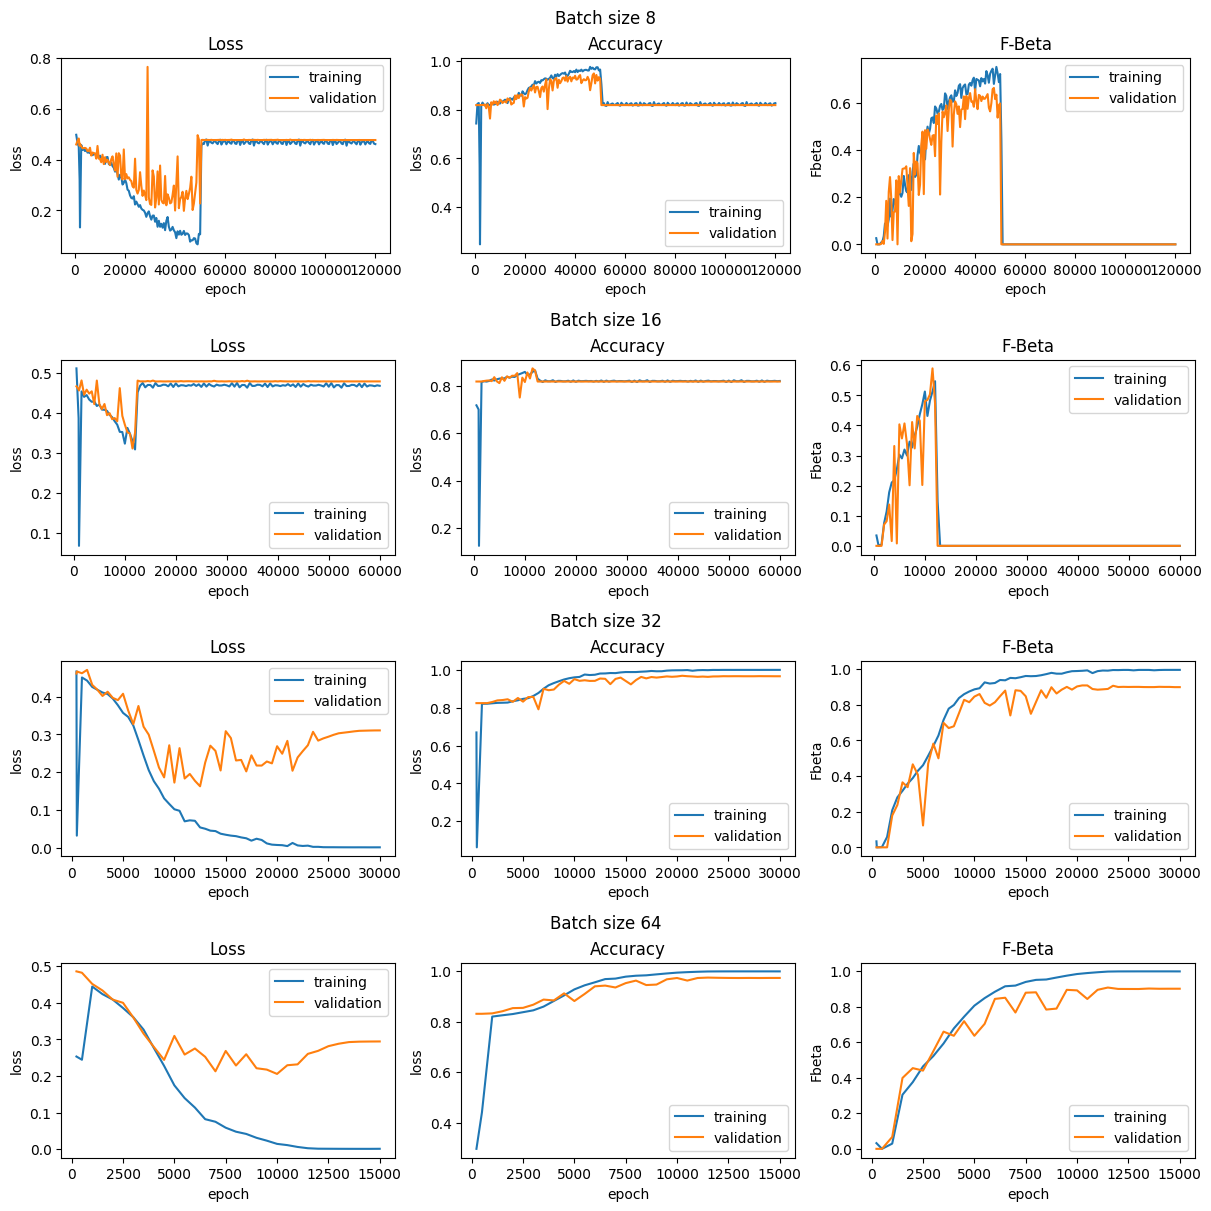

In [79]:
fig = plt.figure(figsize=(12,12), constrained_layout=True)

# create rows x 1 subfigs
subfigs = fig.subfigures(nrows=4, ncols=1)

for row, subfig in enumerate(subfigs):
    batch_size = 2**(row+3)
    trainer = trainers_batches[f'InkDetector_small_dataset_batch_size_{batch_size}']
    subfig.suptitle(f'Batch size {batch_size}')

    # create 1 x cols subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    axs[0].plot(trainer.histories['epochs'], trainer.histories['train_loss'], label="training")
    axs[0].plot(trainer.histories['epochs'], trainer.histories['val_loss'], label="validation")
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].set_title("Loss")
    axs[0].legend()
    
    axs[1].plot(trainer.histories['epochs'], trainer.histories['train_acc'], label="training")
    axs[1].plot(trainer.histories['epochs'], trainer.histories['val_acc'], label="validation")
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('loss')
    axs[1].set_title("Accuracy")
    axs[1].legend()
    
    axs[2].plot(trainer.histories['epochs'], trainer.histories['train_fbeta'], label="training")
    axs[2].plot(trainer.histories['epochs'], trainer.histories['val_fbeta'], label="validation")
    axs[2].set_xlabel('epoch')
    axs[2].set_ylabel('Fbeta')
    axs[2].set_title("F-Beta")
    axs[2].legend()


We see the same issue at batch sizes 8 and 16 as before. Here is a guess as to why. Because my experiment had more epochs in the training regimens for small batch sizes, the learning rate scheduler spent longer at larger learning rates. This gave it more opportunities to overflow the weights. In any case, batch size 32 and 64 both seem fine at this learning rate.

### Layer sets

In [81]:
z_vals = [(8, 0), (8, 8), (8, 16), (8, 24), (8, 32), (8, 40), (8, 48), (8, 56),
          (16, 0), (16, 8), (16, 16), (16, 24), (16, 32), (16, 40), (16, 48),
          (32, 0), (32, 8), (32, 16), (32, 24), (32, 32)]
trainers_z_vals = dict()
for (Z_DIM, Z_START) in z_vals:
    BATCH_SIZE = 32
    LEARNING_RATE = 0.02 # sticking with the smaller learning rate
    MODEL_NAME = f'InkDetector_small_dataset_zstart_{Z_START}_zdim_{Z_DIM}'
    MODEL_SAVE_PATH = "trained_models/" + MODEL_NAME + ".pt"
    TRAINING_EPOCHS = 30000
    VALIDATION_EPOCHS = 500
    BUFFER = 30
    model = InkDetector().to(DEVICE)
    kwargs = {'criterion': nn.BCEWithLogitsLoss(),
              'optimizer': torch.optim.SGD,
              'lr': 0.02,
              'scheduler': torch.optim.lr_scheduler.OneCycleLR,
              'scheduler_total_steps': TRAINING_EPOCHS,
              'scheduler_max_lr': 0.02}
    writer = create_writer(model_name=MODEL_NAME)
    
    PREFIX = Path('data/pieces/train/')
    dsets = []
    for fragment in range(1, 4):
        # read the list of indices
        with open(PREFIX/str(fragment)/'pairs.txt', 'r') as f:
            indices = f.read().split("\n")
        random.seed(28) # should always get the same fragment pieces
        indices_to_use = random.choices(indices, k=4)
        for index in indices_to_use:
            dsets.append(utils.get_rect_dset(PREFIX/str(fragment)/index, Z_START, Z_DIM, BUFFER))
    full_dset = data.ConcatDataset(dsets)
    train_dset, val_dset = train_test_split(full_dset, test_size=0.2, random_state=4)
    
    train_loader = data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False)
    
    tic = time.perf_counter()
    trainer = Trainer(model, train_loader, val_loader, writer=writer, **kwargs)
    print(f"Training {MODEL_NAME}...")
    # save reference to trainer
    trainers_batches[MODEL_NAME] = trainer

    trainer.train_eval_loop(TRAINING_EPOCHS, VALIDATION_EPOCHS)

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    toc = time.perf_counter()
    runtime = toc - tic
    print(f"Finished in {runtime/60:.0f}m{runtime - 60*int(runtime/60):.0f}s")

    # clean up
    del model, train_loader, val_loader, full_dset, dsets


Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_0_zdim_8.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/8 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_0_zdim_8...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 2m59s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_8_zdim_8.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/8 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_8_zdim_8...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 2m59s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_16_zdim_8.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/8 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_16_zdim_8...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 2m57s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_24_zdim_8.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/8 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_24_zdim_8...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 2m57s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_32_zdim_8.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/8 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_32_zdim_8...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 2m59s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_40_zdim_8.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/8 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_40_zdim_8...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 2m1s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_48_zdim_8.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/8 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_48_zdim_8...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 2m52s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_56_zdim_8.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/8 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_56_zdim_8...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 2m51s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_0_zdim_16.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/16 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_0_zdim_16...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 3m40s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_8_zdim_16.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/16 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_8_zdim_16...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 3m35s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_16_zdim_16.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/16 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_16_zdim_16...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 3m38s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_24_zdim_16.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/16 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_24_zdim_16...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 3m36s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_32_zdim_16.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/16 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_32_zdim_16...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 3m36s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_40_zdim_16.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/16 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_40_zdim_16...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 3m38s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_48_zdim_16.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/16 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_48_zdim_16...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 3m39s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_0_zdim_32.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/32 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_0_zdim_32...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 4m21s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_8_zdim_32.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/32 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_8_zdim_32...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 4m21s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_16_zdim_32.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/32 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_16_zdim_32...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 4m21s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_24_zdim_32.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/32 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_24_zdim_32...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 4m21s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_32_zdim_32.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/32 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_32_zdim_32...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 4m21s


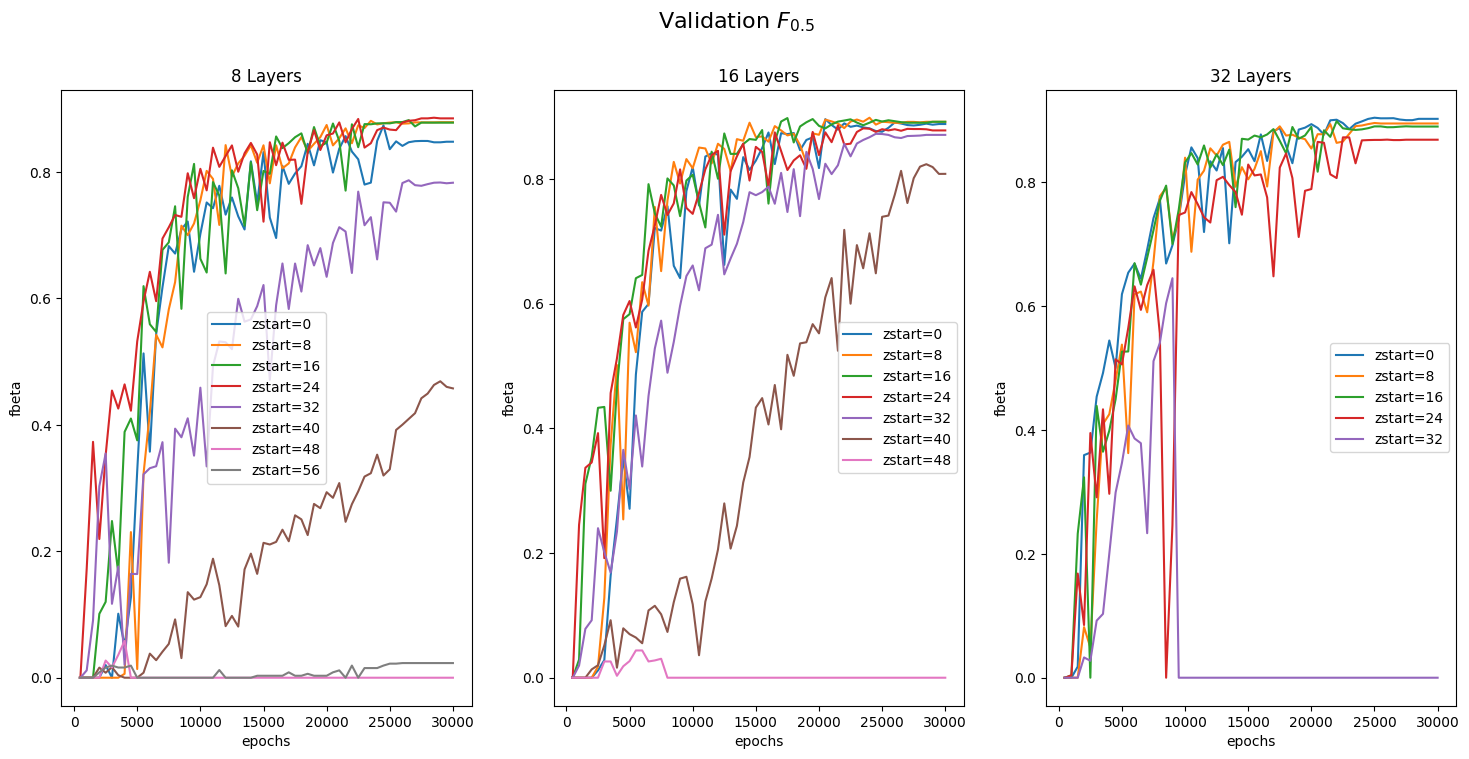

In [89]:
z_vals = [(8, 0), (8, 8), (8, 16), (8, 24), (8, 32), (8, 40), (8, 48), (8, 56),
          (16, 0), (16, 8), (16, 16), (16, 24), (16, 32), (16, 40), (16, 48),
          (32, 0), (32, 8), (32, 16), (32, 24), (32, 32)]
plt.figure(figsize=(18, 8))
plt.suptitle("Validation $F_{0.5}$", fontsize=16)
for z_dim, z_start in z_vals:
    model_name = f'InkDetector_small_dataset_zstart_{z_start}_zdim_{z_dim}'
    if z_dim == 8:
        plt.subplot(131)
        plt.plot(trainers_batches[model_name].histories['epochs'],
                 trainers_batches[model_name].histories['val_fbeta'],
                 label=f'zstart={z_start}')
        plt.xlabel('epochs')
        plt.ylabel('fbeta')
        plt.title('8 Layers')
        plt.legend()
    if z_dim == 16:
        plt.subplot(132)
        plt.plot(trainers_batches[model_name].histories['epochs'],
                 trainers_batches[model_name].histories['val_fbeta'],
                 label=f'zstart={z_start}')
        plt.xlabel('epochs')
        plt.ylabel('fbeta')
        plt.title('16 Layers')
        plt.legend()
    if z_dim == 32:
        plt.subplot(133)
        plt.plot(trainers_batches[model_name].histories['epochs'],
                 trainers_batches[model_name].histories['val_fbeta'],
                 label=f'zstart={z_start}')
        plt.xlabel('epochs')
        plt.ylabel('fbeta')
        plt.title('32 Layers')
        plt.legend()
        
            

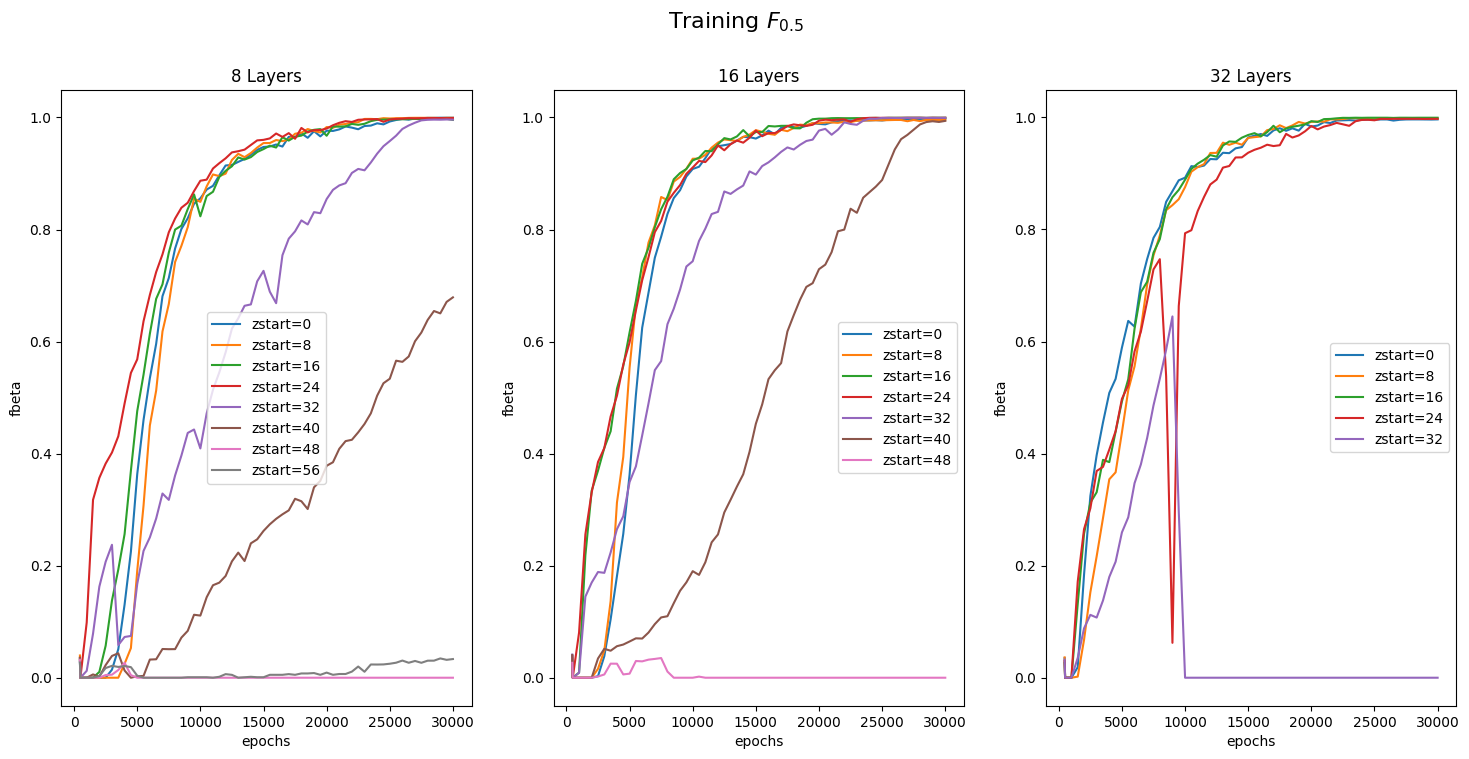

In [92]:
z_vals = [(8, 0), (8, 8), (8, 16), (8, 24), (8, 32), (8, 40), (8, 48), (8, 56),
          (16, 0), (16, 8), (16, 16), (16, 24), (16, 32), (16, 40), (16, 48),
          (32, 0), (32, 8), (32, 16), (32, 24), (32, 32)]
plt.figure(figsize=(18, 8))
plt.suptitle("Training $F_{0.5}$", fontsize=16)
for z_dim, z_start in z_vals:
    model_name = f'InkDetector_small_dataset_zstart_{z_start}_zdim_{z_dim}'
    if z_dim == 8:
        plt.subplot(131)
        plt.plot(trainers_batches[model_name].histories['epochs'],
                 trainers_batches[model_name].histories['train_fbeta'],
                 label=f'zstart={z_start}')
        plt.xlabel('epochs')
        plt.ylabel('fbeta')
        plt.title('8 Layers')
        plt.legend()
    if z_dim == 16:
        plt.subplot(132)
        plt.plot(trainers_batches[model_name].histories['epochs'],
                 trainers_batches[model_name].histories['train_fbeta'],
                 label=f'zstart={z_start}')
        plt.xlabel('epochs')
        plt.ylabel('fbeta')
        plt.title('16 Layers')
        plt.legend()
    if z_dim == 32:
        plt.subplot(133)
        plt.plot(trainers_batches[model_name].histories['epochs'],
                 trainers_batches[model_name].histories['train_fbeta'],
                 label=f'zstart={z_start}')
        plt.xlabel('epochs')
        plt.ylabel('fbeta')
        plt.title('32 Layers')
        plt.legend()
        
            

The first half ($z = 0$ through $z = 32$) appears to contain the bulk of the information. The best `(Z_START, Z_DIM)` pairs, judging from the validation data, are (8, 8), (16, 8), (24, 8); (0, 16), (8, 16), (16, 16); and (0, 32), (8, 32), and (16, 32). A few other pairs such as (40, 16) were able to learn the training data but much more slowly; it's unclear if they would have also reached good performance on the validation data if they had more time. Models that only had access to the highest layers generally died.

In [96]:
# I saved the trainer data in the wrong dict, so let me move it to a new one
z_keys = []
for key in trainers_batches.keys():
    if 'zstart' in key:
        print(key)
        z_keys.append(key)
        trainers_z_vals[key] = trainers_batches[key]
for key in z_keys:
    del trainers_batches[key]

InkDetector_small_dataset_zstart_8_zdim_8
InkDetector_small_dataset_zstart_16_zdim_8
InkDetector_small_dataset_zstart_24_zdim_8
InkDetector_small_dataset_zstart_32_zdim_8
InkDetector_small_dataset_zstart_40_zdim_8
InkDetector_small_dataset_zstart_48_zdim_8
InkDetector_small_dataset_zstart_56_zdim_8
InkDetector_small_dataset_zstart_0_zdim_16
InkDetector_small_dataset_zstart_8_zdim_16
InkDetector_small_dataset_zstart_16_zdim_16
InkDetector_small_dataset_zstart_24_zdim_16
InkDetector_small_dataset_zstart_32_zdim_16
InkDetector_small_dataset_zstart_40_zdim_16
InkDetector_small_dataset_zstart_48_zdim_16
InkDetector_small_dataset_zstart_0_zdim_32
InkDetector_small_dataset_zstart_8_zdim_32
InkDetector_small_dataset_zstart_16_zdim_32
InkDetector_small_dataset_zstart_24_zdim_32
InkDetector_small_dataset_zstart_32_zdim_32


### Buffer sizes
I'll test the best-performing z-values, identified above, using a smaller and a larger buffer size.

In [97]:
z_vals = [(8, 8), (16, 8), (24, 8), (0, 16), (8, 16), (16, 16), (0, 32), (8, 32), (16, 32)]
buffers = [15, 45]
trainers_buffers = dict()
for Z_START, Z_DIM in z_vals:
    for BUFFER in buffers:
        BATCH_SIZE = 32
        LEARNING_RATE = 0.02
        MODEL_NAME = f'InkDetector_small_dataset_zstart_{Z_START}_zdim_{Z_DIM}_buffer_{BUFFER}'
        MODEL_SAVE_PATH = "trained_models/" + MODEL_NAME + ".pt"
        TRAINING_EPOCHS = 30000
        VALIDATION_EPOCHS = 500
        model = InkDetector().to(DEVICE)
        kwargs = {'criterion': nn.BCEWithLogitsLoss(),
                  'optimizer': torch.optim.SGD,
                  'lr': 0.02,
                  'scheduler': torch.optim.lr_scheduler.OneCycleLR,
                  'scheduler_total_steps': TRAINING_EPOCHS,
                  'scheduler_max_lr': 0.02}
        writer = create_writer(model_name=MODEL_NAME)

        PREFIX = Path('data/pieces/train/')
        dsets = []
        for fragment in range(1, 4):
            # read the list of indices
            with open(PREFIX/str(fragment)/'pairs.txt', 'r') as f:
                indices = f.read().split("\n")
            random.seed(28) # should always get the same fragment pieces
            indices_to_use = random.choices(indices, k=4)
            for index in indices_to_use:
                dsets.append(utils.get_rect_dset(PREFIX/str(fragment)/index, Z_START, Z_DIM, BUFFER))
        full_dset = data.ConcatDataset(dsets)
        train_dset, val_dset = train_test_split(full_dset, test_size=0.2, random_state=4)

        train_loader = data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False)

        tic = time.perf_counter()
        trainer = Trainer(model, train_loader, val_loader, writer=writer, **kwargs)
        print(f"Training {MODEL_NAME}...")
        # save reference to trainer
        trainers_buffers[MODEL_NAME] = trainer

        trainer.train_eval_loop(TRAINING_EPOCHS, VALIDATION_EPOCHS)

        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        toc = time.perf_counter()
        runtime = toc - tic
        print(f"Finished in {runtime/60:.0f}m{runtime - 60*int(runtime/60):.0f}s")

        # clean up
        del model, train_loader, val_loader, full_dset, dsets

Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_8_zdim_8_buffer_15.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/8 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_8_zdim_8_buffer_15...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 1m28s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_8_zdim_8_buffer_45.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/8 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_8_zdim_8_buffer_45...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 3m51s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_16_zdim_8_buffer_15.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/8 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_16_zdim_8_buffer_15...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 2m30s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_16_zdim_8_buffer_45.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/8 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_16_zdim_8_buffer_45...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 3m51s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_24_zdim_8_buffer_15.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/8 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_24_zdim_8_buffer_15...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 1m27s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_24_zdim_8_buffer_45.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/8 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_24_zdim_8_buffer_45...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 3m53s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_0_zdim_16_buffer_15.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/16 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_0_zdim_16_buffer_15...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 2m39s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_0_zdim_16_buffer_45.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/16 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_0_zdim_16_buffer_45...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 5m39s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_8_zdim_16_buffer_15.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/16 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_8_zdim_16_buffer_15...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 2m40s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_8_zdim_16_buffer_45.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/16 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_8_zdim_16_buffer_45...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 5m40s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_16_zdim_16_buffer_15.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/16 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_16_zdim_16_buffer_15...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 2m41s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_16_zdim_16_buffer_45.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/16 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/16 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_16_zdim_16_buffer_45...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 5m35s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_0_zdim_32_buffer_15.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/32 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_0_zdim_32_buffer_15...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 2m59s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_0_zdim_32_buffer_45.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/32 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_0_zdim_32_buffer_45...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 10m37s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_8_zdim_32_buffer_15.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/32 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_8_zdim_32_buffer_15...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 2m59s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_8_zdim_32_buffer_45.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/32 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_8_zdim_32_buffer_45...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 10m47s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_16_zdim_32_buffer_15.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/32 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_16_zdim_32_buffer_15...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 2m2s
Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_zstart_16_zdim_32_buffer_45.


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/32 [00:00<?, ?it/s]

Training InkDetector_small_dataset_zstart_16_zdim_32_buffer_45...


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 10m38s


Here I think the trend is clear: bigger buffer sizes perform better, and we could consider trying even larger buffer sizes!

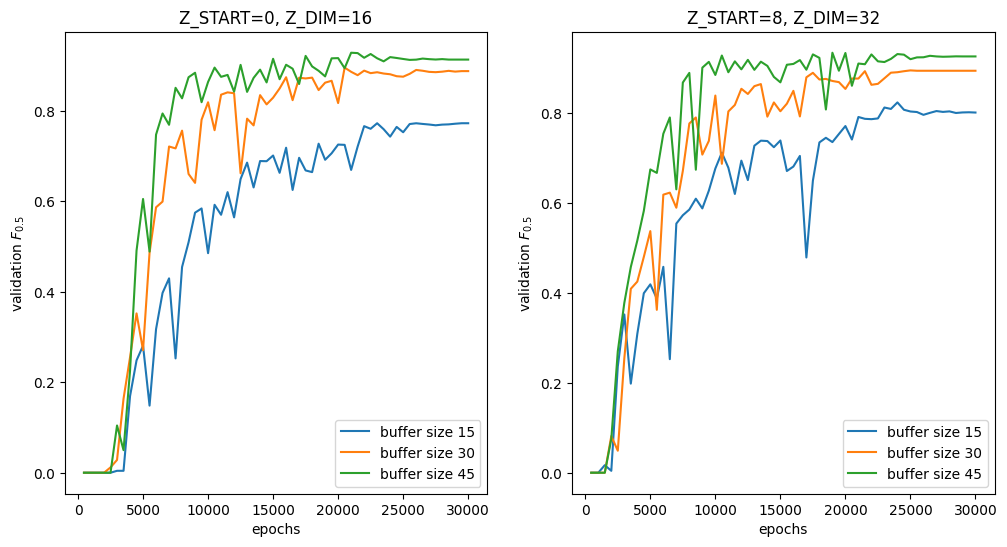

In [102]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
Z_START, Z_DIM = 0, 16
BUFFER = 15
model_name = f'InkDetector_small_dataset_zstart_{Z_START}_zdim_{Z_DIM}_buffer_{BUFFER}'
plt.plot(trainers_buffers[model_name].histories['epochs'],
         trainers_buffers[model_name].histories['val_fbeta'],
         label=f"buffer size {BUFFER}")
plt.plot(trainers_z_vals[f'InkDetector_small_dataset_zstart_{Z_START}_zdim_{Z_DIM}'].histories['epochs'],
         trainers_z_vals[f'InkDetector_small_dataset_zstart_{Z_START}_zdim_{Z_DIM}'].histories['val_fbeta'],
         label=f"buffer size 30")
BUFFER = 45
model_name = f'InkDetector_small_dataset_zstart_{Z_START}_zdim_{Z_DIM}_buffer_{BUFFER}'
plt.plot(trainers_buffers[model_name].histories['epochs'],
         trainers_buffers[model_name].histories['val_fbeta'],
         label=f"buffer size {BUFFER}")
plt.xlabel('epochs')
plt.ylabel('validation $F_{0.5}$')
plt.title(f"Z_START={Z_START}, Z_DIM={Z_DIM}")
plt.legend()
plt.subplot(122)
Z_START, Z_DIM = 8, 32
BUFFER = 15
model_name = f'InkDetector_small_dataset_zstart_{Z_START}_zdim_{Z_DIM}_buffer_{BUFFER}'
plt.plot(trainers_buffers[model_name].histories['epochs'],
         trainers_buffers[model_name].histories['val_fbeta'],
         label=f"buffer size {BUFFER}")
plt.plot(trainers_z_vals[f'InkDetector_small_dataset_zstart_{Z_START}_zdim_{Z_DIM}'].histories['epochs'],
         trainers_z_vals[f'InkDetector_small_dataset_zstart_{Z_START}_zdim_{Z_DIM}'].histories['val_fbeta'],
         label=f"buffer size 30")
BUFFER = 45
model_name = f'InkDetector_small_dataset_zstart_{Z_START}_zdim_{Z_DIM}_buffer_{BUFFER}'
plt.plot(trainers_buffers[model_name].histories['epochs'],
         trainers_buffers[model_name].histories['val_fbeta'],
         label=f"buffer size {BUFFER}")
plt.xlabel('epochs')
plt.ylabel('validation $F_{0.5}$')
plt.title(f"Z_START={Z_START}, Z_DIM={Z_DIM}")
plt.legend();

In [127]:
final_fbetas = []
for trainer_dict in [trainers, trainers_batches, trainers_z_vals, trainers_buffers]:
    for model_name in trainer_dict.keys():
        final_fbetas.append((trainer_dict[model_name].histories["val_fbeta"][-1], model_name))
final_fbetas.sort(reverse=True)
print("Validation F_{0.5} at end of training")
print(".....................................")
for fbeta, model_name in final_fbetas:
    print(f'{model_name:<54}: {fbeta:>4.3f}')

Validation F_{0.5} at end of training
.....................................
InkDetector_small_dataset_zstart_16_zdim_16_buffer_45 : 0.930
InkDetector_small_dataset_zstart_8_zdim_32_buffer_45  : 0.927
InkDetector_small_dataset_zstart_8_zdim_16_buffer_45  : 0.925
InkDetector_small_dataset_zstart_8_zdim_8_buffer_45   : 0.921
InkDetector_small_dataset_zstart_0_zdim_32_buffer_45  : 0.920
InkDetector_small_dataset_zstart_24_zdim_8_buffer_45  : 0.920
InkDetector_small_dataset_zstart_16_zdim_32_buffer_45 : 0.915
InkDetector_small_dataset_zstart_0_zdim_16_buffer_45  : 0.914
InkDetector_small_dataset_zstart_16_zdim_8_buffer_45  : 0.911
InkDetector_small_dataset_zstart_0_zdim_32            : 0.902
InkDetector_small_dataset_batch_size_64               : 0.902
InkDetector_small_dataset_batch_size_32               : 0.898
InkDetector_small_dataset_zstart_8_zdim_32            : 0.895
InkDetector_small_dataset_zstart_16_zdim_16           : 0.892
InkDetector_small_dataset_zstart_8_zdim_16            : 

In [129]:
import pickle
all_histories = {'trainers': {name: trainers[name].histories for name in trainers},
                 'trainers_batches': {name: trainers_batches[name].histories for name in trainers_batches},
                 'trainers_z_vals': {name: trainers_z_vals[name].histories for name in trainers_z_vals},
                 'trainers_buffers': {name: trainers_buffers[name].histories for name in trainers_buffers}}
with open('logs/experiments_histories.pkl', 'wb') as f:
    pickle.dump(all_histories, f)